# COGS 118A - Final Project

# Applying a Monte Carlo Tree Search to Connect 4

## Group members
- Kimberly Rose Johnson
- Ana Cunha
- Esmeralda Mejia Trejo

# Abstract 
Connect 4 is a popular 2 player game in which players take turns placing pieces in a 6 X 7 grid board. The objective is for a player to have 4 of their pieces connected in a horizontal, vertical, or diagonal line. Our goal is to design an AI that plays a perfect game of Connect 4 every time, regardless of what move the opponent makes, by training our model using reinforced learning in Kaggle's Connect X simulation environment. Our approach will consist of using a Monte Carlo Tree Search in order for the AI to learn the best choice of action when playing the game. 

# Background

Solving games through the use of artificial intelligence has historically been a topic of interest and the skills
needed to perform this task can be of use in a variety of other fields. A game is considered "solved" when
its "outcome (win, lose or draw) can be correctly predicted from any position, assuming that both players
play perfectly" <a name="Wikipedia"></a1>[<sup>[1]</sup>](#Wikipedia). Connect 4 is considered a solved game. It
was first solved in 1988 with a knowledge based approach and was solved with a brute force approach
in 1995 that utilized an 8-ply database <a name="Wikipedia"></a1>[<sup>[1]</sup>](#Wikipedia). Using databases
to solve games is a form of retrograde analysis, which is a technique "in which for each position of some specific game
or endgame the optimal moves towards the best reachable goal is stored" <a name="Heule and Rothkrantz"></a2>[<sup>[2]</sup>](#Heule and Rothkrantz). This approach is a form of reinforced learning, which is the optimal solution for solving Connect 4 <a name="Stephen Jarrel"></a3>[<sup>[3]</sup>](#Stephen Jarrel). Reinforced Learning is a machine learning method which trains an agent to "achieve an optimal solution" by assigning positive values to desirable actions and negative values to undesirable actions <a name="Carew, Joseph M."></a4>[<sup>[4]</sup>](#Carew, Joseph M.). A reinforcement learning milestone took place in 2016 when AlphaGo, created by Google's DeepMind, beat the number 2 ranked professional Go player in the world, Lee Sidol
 <a name="Choudhary, Ankit"></a5>[<sup>[5]</sup>](#Choudhary, Ankit). The key algorithm used in AlphaGo, and many other gaming AIs, is the Monte Carlo Tree Search (MCTS), which finds the optimal move given the current state of the game by balancing the principle  of exploitation versus exploration. AlphaGo was designed with Convolutional Neural Networks (CNN) in addition to MCTS to produce optimal results by removing the rollout phase of the MCTS and replacing it with a probablity vector from the CNN to guide the decision making process.  Our research will utilize MCTS with CNN to create a Connect 4 AI.  

# Problem Statement

Currently, there are a lot of AI developments especially in gaming. However, some research has pointed to the fact that there is still a lot of room for further advancements. In our project, we aim to create an AI that would beat the user every time in a game of Connect-4. We will accomplish this by creating an efficient Monte Carlo algorithm that is capable of making next play decisions by evaluating positions in the current state of the board and calculating the probability of winning from each position in order to select the optimal move.

# Data

A MCTS is not constructed from analysis of a data set. In is a reinforcement learning algorithm that collects data in the form of observations from the environment through gameplay. As such, our data only consists of simulation results.

# Proposed Solution

Essentially, the question we want to answer is: how can we make an AI bot that can learn the best way to win a Connect-4 match?
When making an AI that can play Connect-4, what is needed is essentially a 6x7 grid board and a function that can select a randomized column choice of 1-6 to fill the space in the game board. The problem with this, is that it will always be random and the AI won't learn anything which means that it may not get better at playing over time. We propose to have the AI learn through reinforcement learning. In reinforcement learning, the agent (model), interacts with an environment and receives feedback about the outcome which is used to train the model to make optimized decisions. In order to accomplish this, we will implement a MCTS algorithm and then test, train, and evaluate it using Kaggle's ConnectX environment. The ConnectX environment provides a Connect4 simulation along with 2 built in AIs. One ai implements a simple random choice of moves and the other implements a min-max algorithm. The environment also contains variables which hold information about the game such as the state of the board, allotted time to make moves, and other configurable parameters such as number of rows or columns. We will be using the traditional number of rows and columns, 6 and 7, respectively. The Monte Carlo Tree Search consists of the following steps:

**Selection**: In this step, the tree will construct a path from the root to the most promising node. It then uses the Upper Confidence Bound for Trees (UCT) formula. The Upper Confidence Bound for Trees (UCT) is a formula
which balances the exploration/exploitation trade off. Exploration is exploring moves which may possibly be good and exploitation is selecting moves with the
highest chance of winning, while this may seem to be the best idea, lack of exploration may lead to missing really good moves. Exploitation follows a depth first search pattern by traversing trees to greater depths on each branch, and exploration follows a breadth first search pattern by visiting more branches but traversing less paths. The formula contains a variable metric c which is used to increase or decrease the level of exploration.

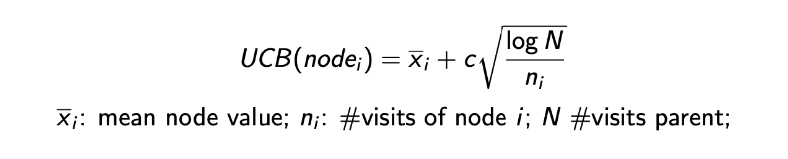





**Expansion**: In expansion, a randomly picked unexplored child node is chosen.

**Simulation**: In this step, several simulations take place in which the entirety of the game is played out from an existing position on the board.The end result, a win or loss (+1, - 1) for the current player, is stored in the nodes and branches that were followed, through back propagation, and used to guide future decisions. Ultimately, nodes which led to paths in which the current player won will be assigned higher values.

**Backpropagation**: After the value of the newly added node is determined, the rest of the tree will be updated. This is where the backpropagation process comes into play and it backpropagates from the new node to the root node. While this happens, the number of simulations stored in each node increases. Along the way, it keeps track of the number of wins.<a name="sota"></a>[<sup>[4]</sup>](#sotanote)
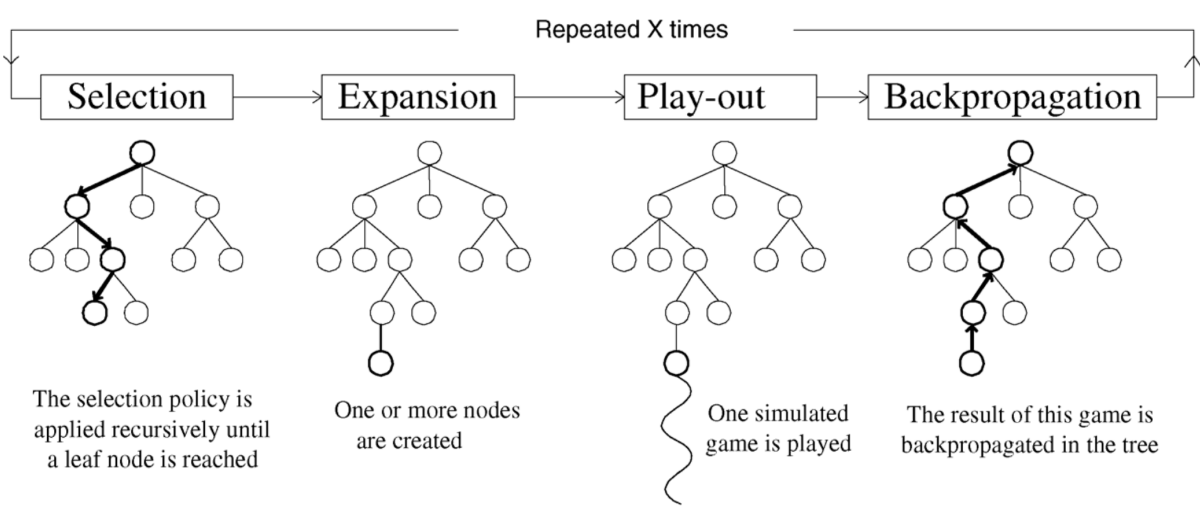


# Evaluation Metrics

The performance of the model can be evaluated by calculating the percentage of wins against another model
for a specified number of simulations. A function included on line 141 of our code, provided by Kaggle for use with the ConnectX environment, calculates the performance of the model. Furthermore, the exploration parameter C, which dictates whether the algorithm prefers selecting nodes with the highest chance of winning or least visits, can be adjusted in order to modify the results. Higher values of C will increase exploration and lower values increase exploitation.

In [ ]:
import math
import numpy as np
import time
import random
import kaggle_environments
from kaggle_environments import make, evaluate, utils

# C parameter to control the level of exploration
EXPLORATION = 1.3

# number of rounds to conduct evaluations
NUM_ROUNDS = 500

# an amount of time to run
RUN_TIME = 45

###############################################################################################
#        HELPER FUNCTIONS FROM KAGGLE TO AID IN IMPLEMENTING AGENTS FOR THE GAME SIM          #
###############################################################################################

# Gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, piece):
    next_grid = grid.copy()
    for row in range(6 - 1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = piece
    #print(f'Inside drop piece returning this board {next_grid}')
    return next_grid


# Returns True if there is a win
def check_for_win(grid, config, piece):
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[row, col:col + config.inarow])
            if window.count(piece) == config.inarow:
                return True
    # vertical
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns):
            window = list(grid[row:row + config.inarow, col])
            if window.count(piece) == config.inarow:
                return True
    # positive diagonal
    for row in range(config.rows - (config.inarow - 1)):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row + config.inarow), range(col, col + config.inarow)])
            if window.count(piece) == config.inarow:
                return True
    # negative diagonal
    for row in range(config.inarow - 1, config.rows):
        for col in range(config.columns - (config.inarow - 1)):
            window = list(grid[range(row, row - config.inarow, -1), range(col, col + config.inarow)])
            if window.count(piece) == config.inarow:
                return True
    return False

def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

##############################################################################################################
class Node(object):
    '''
       This class represents a node in the
       MCTS

       Fields:

             board: the board recreated from state
             parent: the parent node which led to this node
             move: the last move that led to this node
             children: a list of this node's children
             win_counts: number of wins generated from this node
             num_rollouts: number of rollouts from this node
             unvisited_moves: potential valid moves which have not been explored
    '''

    def __init__(self, board, player, moves_to_make, parent=None, move=None):
        self.board = board
        self.player = player
        self.parent = parent
        self.move = move
        self.win_counts = {
            1: 0,
            2: 0
        }
        self.num_rollouts = 0
        self.children = []
        self.unvisited_moves = moves_to_make

    def add_child(self):
        '''
           Adds a child to the tree by randomly selecting from the list
           of valid moves

           Returns:
               the child node which was added
        '''
        # get a random move from the unvisited moves by using random int to select an index
        move = self.unvisited_moves.pop((random.randint(0, len(self.unvisited_moves) - 1)))

        # apply the move to generate a new board state which contains the move.
        new_board = drop_piece(self.board, move, self.player)

        moves = valid_moves(new_board)

        # create a new node which contains the updated board
        new_node = Node(new_board, self.player, moves, self, move)
        self.children.append(new_node)
        return new_node

    def record_win(self, winner):
        '''
           Record the winning player, 1 or 2
        '''
        self.win_counts[winner] += 1
        self.num_rollouts += 1

    def can_add_child(self):
        '''
           Check if it is possible to add a child
           there can only be as many children added
           as there are valid moves

           Return:
               true if there are more moves to explore,
               false otherwise
        '''
        return len(self.unvisited_moves) > 0

    def is_game_over(self, board, config, node):
        '''
           Check if a player has won or all moves have been
           played.

           Return:
               true if game is over, false otherwise
        '''
        player1_has_won = check_for_win(board, config, 1)
        player2_has_won = check_for_win(board, config, 2)
        return player1_has_won or player2_has_won or node.unvisited_moves == 0

    def percent_wins(self, player):
        '''
           Get the percentage of wins for a player

           Return:
                percentage of wins for a player
        '''
        return float(self.win_counts[player]) / float(self.num_rollouts) if self.num_rollouts != 0 else 0.0

class Agent:
    def __init__(self, state, config):
        '''
           state: the state of the game passed from the simulation
           config: board configurations passed from the simulation
           num_rounds: a number of rounds to run the simulation to check moves
        '''
        self.num_rounds = NUM_ROUNDS  # for running a number of rounds
        self.run_time = RUN_TIME  # for running a number of seconds
        self.state = state
        self.config = config
        self.player = state.get('mark')

    def select_move(self):
        '''
           Given a game state, select a move

           Return:
               a move to select
        '''
        board = np.array(self.state.board).reshape(6, 7)
        moves = valid_moves(board)
        # print(f'Valid moves: {moves}')
        root = Node(board, self.player, moves)
        best_move = None
        total_time = 0

        while total_time < self.run_time:
            start = time.time()
            node = root
            # print(f'Entering select move. board = {node.board}')
            #print(f'Entering select move. player = {node.player}')
            #print(f'Entering select move. moves = {node.unvisited_moves}')

            if node is not None:
                if node.can_add_child():
                    node.add_child()

                if not node.can_add_child() and not node.is_game_over(board, self.config, node):
                    node = self.select_child(node)

                winner = self.simulate(node)

                while node is not None:
                    node.record_win(winner)
                    node = node.parent

                best_move = None
                best_percentage = -1.0

                for child in root.children:
                    child_percentage = child.percent_wins(child.player)

                    if child_percentage > best_percentage:
                        best_percentage = child_percentage
                        best_move = child.move
            end = time.time()
            total_time += (end - start)
        return best_move

    def select_child(self, node):
        '''
           Select the best child by utilizing the UCT formula

           Args:
               node: a node to start at

           Returns:
               the best child node
        '''
        total_rollouts = sum(child.num_rollouts for child in node.children)
        best_score = -1
        best_child = None

        for child in node.children:
            score = uct(total_rollouts, child.num_rollouts,
                        child.percent_wins(child.player), EXPLORATION)

            if score > best_score:
                best_score = score
                best_child = child
        return best_child

    def simulate(self, node):
        '''
           Given a node, simulate a game from the node's state
           and return a winner

           Args:
                 node: a node to start from

           Return:
                 a winning player, 1 or 2
       '''
        current_board = node.board
        #print(f'Calling simulate')
        #print(f'Inside simulate current board = {current_board}')
        player = node.player
        opponent = 1 if player == 1 else 2
        game_over = node.is_game_over(current_board, self.config, node)
        last_player = opponent
        winner = player

        while not game_over:

            #print(f'Inside simulate current_board = {current_board}')
            available_moves = valid_moves(current_board)

            if len(available_moves) == 0:
                winning_player = None
                game_over = True
                break

            else:
                move = available_moves.pop((random.randint(0, len(available_moves) - 1)))

                if last_player == opponent:
                    current_board = drop_piece(current_board, move, player)
                    last_player = player

                else:
                    current_board = drop_piece(current_board, move, opponent)
                    last_player = opponent

                has_win_1 = check_for_win(current_board, self.config, player)
                has_win_2 = check_for_win(current_board, self.config, opponent)

                if has_win_1 or has_win_2:
                    game_over = True
                    winner = player if has_win_1 else opponent
                    break

        #print(f'FINAL board from simulation {current_board}')
        return winner

env = make("connectx", debug=True)

env.reset()

env.run([agent_mcts, 'negamax'])
x = env.render(mode="ipython", width=500, height=450)

get_win_percentages(agent1=agent_mcts, agent2="negamax")

# Results

We had originally wanted to implement a neural network to eliminate the rollout phase of the MCTS and optimize its performance. This was what the AlphaGoZero project had accomplished for the game Go. Unfortunately, we encountered the following issues:
- Uncertainty about how to pass the state of the board to the neural network for evaluation and how to process the results obtained from the network in order to select a move.
- How to integrate the neural network into the MCTS implementation as well as the ConnectX environment.

A substantial amount of time was committed to the implementation with the neural network and we had to abandon it due to time restrictions. Our current implementation using only an MCTS algorithm was successfully integrated into the ConnectX environment, but is not producing the desired results.


# Discussion

### Interpreting the result

While unsuccessful in what we had hoped to accomplish, we have gained knowledge of how reinforcement
learning is used to inform the decision-making process of a Monte Carlo Tree Search algorithm through
balancing exploration and exploitation. Furthermore, we have learned this process can be further enhanced by providing the state of the game board to a neural network which will output a probability vector in order to guide the process.

### Limitations

For our project, we focused heavily on monte carlo search trees, which are a great way to find the best strategies in a Connect4 game. However, like any other machine learning methods, it also has limitations.

Our main limitation with this project was that, although we were using machine learning principles, it is difficult to evaluate the performance. The techniques for evaluating performance of supervised machine learning algorithms are not applicable to MCTS and since MCTS was not available in a library, any evaluation metrics would have needed to be custom built like the algorithm. The neural network we had hoped to implement would have had performance analytics available through TensorFlow.

Although MCTS requires an elevated number of iterations to be able to effectively reach a solution, too many iterations can lead to an overreach and not give us the prime results we are looking for. Furthermore, as the tree expands while searching, the algorithm becomes computationally expensive and
as a consequence of this high number of iterations, MCTS takes a long time to find the most efficient answer, resulting in slow performance and a high memory requirement. We had hoped to mitigate the number of iterations by implementing a neural network to eliminate the rollout phase and better guide the decision-making process. Unfortunately, we were too limited on time to properly construct a neural network.

Another important disadvantage to consider with MCTS is the fact that some moves during the game may look (superficially) like the best move to be made, sometimes, depending on the complexity of the game, there could be a subtle play that will pay out in the long run. The MCTS would find it very difficult to "see" this play due to its selective node expansion.

### Ethics & Privacy

Privacy is not a concern with our project but ethics certainly could be. Any AI built to solve games can be used to cheat in those same games. Furthermore, solutions and/or algorithms could be taken and used toconstruct an AI for the purpose of cheating in a different game.

### Conclusion

With continued research and more time we believe we could implement the MCTS with a neural network

# Resources

The following resources were used to aid in the implementation of algorithms as well as
inform us about the topics.

- Pumperla, Max and Ferguson, Kevin. Deep Learning and the Game of Go. Copyright: www.manning.com
- Foster, David. How to build your own AlphaZero AI Using Python and Keras. https://medium.com/applied-data-science/how-to-build-your-own-alphazero-ai-using-python-and-keras-7f664945c188
- Agarwal, Pranav. Game AI: Learning to Play Connect 4 Using Monte Carlo Tree Search. https://pranav-agarwal-2109.medium.com/game-ai-learning-to-play-connect-4-using-monte-carlo-tree-search-f083d7da451e

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem

<a name="sotanote"></a>4.[^](#sota): “ML: Monte Carlo Tree Search (MCTS).” GeeksforGeeks, 19 Jan. 2022, https://www.geeksforgeeks.org/ml-monte-carlo-tree-search-mcts/. 